BlockSeparation+NonLinearEncoder+LocationEmbedding+UNetdecoder

*5 attempts*

4*4kernel,1:8,

In [723]:
import torch#
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys
import time
import pandas as pd
import os

In [724]:
from skimage.metrics import structural_similarity as ssim_loss

In [725]:

from datetime import datetime
now = datetime.now()
formatted_date = now.strftime("%m%d")
formatted_date = int(formatted_date)
print(formatted_date)

import os
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)
save_directory = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoEncoder_data005', 'CIFAR10_NL1-8_result') #保存先のファイル名を入力
print(save_directory)
os.makedirs(save_directory, exist_ok=True)


1226
C:\Users\Scent\OneDrive\CODES\konishi_AutoEncoder\AutoEncoder_data005\CIFAR10_NL1-8_result


In [726]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [727]:
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)

root = os.path.join(onedrive_path, 'CODES', 'samples', 'cifar10_data')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0),  
                         (1, 1, 1)), 
])

cifar10_train = datasets.CIFAR10(root=root, download=True, train=True, transform=transform)
cifar10_test = datasets.CIFAR10(root=root, download=True, train=False, transform=transform)

train_dataloader = DataLoader(cifar10_train, batch_size=128, shuffle=True)
test_dataloader = DataLoader(cifar10_test, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [728]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [729]:
def split_into_kernels(image, kernel_size):
    b,c,h,w = image.shape
    kernels = image.unfold(2, kernel_size, kernel_size).unfold(3, kernel_size, kernel_size)
    kernels = kernels.contiguous().view(b, c, -1, kernel_size, kernel_size)
    kernels = kernels.permute(0, 2, 1, 3, 4)# (b, n_patches, c, kernel_size, kernel_size)
    return kernels

In [731]:
#Encoder5DX(パッチ分割，位置埋め込みを想定)
class Encoder(nn.Module):
    def __init__(self,kernel_size,leverage,channels,alpha=1.2):
        super(Encoder, self).__init__()
        self.kernel_size = kernel_size
        self.leverage = leverage
        self.alpha = alpha

        kernel_in = kernel_size ** 2 * channels
        output_dim = int(kernel_in/leverage)
        phase = torch.rand(output_dim, kernel_in) * 2 * np.pi - np.pi
        modulus = torch.ones(output_dim, kernel_in)
        # modulus = torch.rand(output_dim, kernel_in)

        # 複素数を生成 (r * exp(iθ) = r * (cos(θ) + i*sin(θ)))
        real_part = modulus * torch.cos(phase)
        imag_part = modulus * torch.sin(phase)

        self.B = torch.complex(real_part, imag_part).detach().to(device)
        self.B.requires_grad = False

        #self.ln = nn.LayerNorm(normalized_shape=int(kernel_in/leverage))##

    def forward(self, x):
        b, n_patches, c, k, _ = x.shape# (b, n_patches, c, kernel_size, kernel_size)
        x = x.reshape(b*n_patches, -1)  #(b*p,c*k*k)
        x = torch.exp(1j * self.alpha * x) 
        x = x.T  
        x = torch.matmul(self.B, x).T  #(b*p,c*k*k/l)
        x = torch.abs(x)**2 
        return x, n_patches 
    

In [732]:
class PositionalEmbedder(nn.Module):
    def __init__(self, img_size, kernel_size, pos_embed_dim=8):
        super(PositionalEmbedder, self).__init__()
        self.kernel_size = kernel_size
        self.img_size = img_size
        self.pos_embed_dim = pos_embed_dim

        self.num_patches_x = img_size // kernel_size
        self.num_patches_y = img_size // kernel_size


        self.embed_x = nn.Embedding(self.num_patches_x, self.pos_embed_dim)
        self.embed_y = nn.Embedding(self.num_patches_y, self.pos_embed_dim)

    def forward(self, x, b, n_patches):
        #(b*p,c*k*k/l)
       
        patch_ids = torch.arange(n_patches, device=x.device)#全パッチに一意のIDを割り振る。

        ix = patch_ids % self.num_patches_x
        iy = patch_ids // self.num_patches_x

        pos_x = self.embed_x(ix) 
        pos_y = self.embed_y(iy) 

        pos_info = torch.cat([pos_x, pos_y], dim=1) 
        pos_info = pos_info.unsqueeze(0).expand(b, -1, -1).contiguous().view(b*n_patches, -1)

        x = torch.cat([x, pos_info], dim=1) 
        x = x.view(b, n_patches, -1)
        x = x.view(b, -1)
        return x#(b,p*c*k*k/l)

In [733]:
class PreBlock(nn.Module):
    """
    Decoderに入る前に、EncoderBの出力をさらに学習的に再マッピングする層。
    例えば: 
     - 少し大きめのfc -> BN/LN -> ReLU
     - or GroupNorm1d, LayerNorm, など
    """
    def __init__(self, in_dim, out_dim, use_ln):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        self.relu = nn.LeakyReLU(inplace=True)
        self.use_ln = use_ln
        if use_ln:
            self.ln = nn.LayerNorm(out_dim)

    def forward(self, x):
        x = self.fc(x)       # (B, out_dim)
        if self.use_ln:
            x = self.ln(x)
        x = self.relu(x)
        return x


In [735]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        #self.gn1 = nn.GroupNorm(num_groups=8, num_channels=out_channels)
        self.relu = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        #self.gn2 = nn.GroupNorm(num_groups=8, num_channels=out_channels)
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        else:
            self.shortcut = None

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.shortcut is not None:
            residual = self.shortcut(residual)#outと同じチャンネル数に合わせる
        out += residual#残差接続
        out = self.relu(out)
        return out
    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(inplace=True)

    def forward(self, x):
        x = self.up(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class UNetDecoder(nn.Module):
    def __init__(self, num_in,ch,img_size):
        super(UNetDecoder, self).__init__()

        self.ch = ch

        self.map_pic = img_size//4

        self.pre = PreBlock(in_dim=num_in, out_dim=ch*self.map_pic*self.map_pic, use_ln=True)

        #self.fc = nn.Linear(num_in, ch*self.map_pic*self.map_pic)
        self.bottleneck = ResidualBlock(ch,ch,3)
        self.up1 = UpBlock(ch,ch)
        self.res1 = ResidualBlock(ch+ch,ch,3)
        self.up2 = UpBlock(ch,ch)
        self.res2 = ResidualBlock(ch+ch,ch,3)
        self.out_conv = nn.Conv2d(ch+ch, 3, 1, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        #(b,p*c*k*k/l)
        b = x.size(0)
        x = self.pre(x)
        x = x.view(b, self.ch, self.map_pic, self.map_pic) 
        x0 = self.bottleneck(x)  
        x1 = self.up1(x0) 
        x0_upsampled = F.interpolate(x0, scale_factor=2, mode='nearest') 
        x1 = torch.cat([x1, x0_upsampled], dim=1)
        x1 = self.res1(x1)
        x2 = self.up2(x1)
        x1_up = F.interpolate(x1, scale_factor=2, mode='nearest')
        x2 = torch.cat([x2, x1_up], dim=1)
        x_out = self.out_conv(x2)
        x_out = self.sigmoid(x_out) 
        x_out = x_out.view(b, -1)  
        return x_out#(b,p*c*k*k/l)


In [737]:
class AutoEncoder(nn.Module):
    def __init__(self, img_size,channels, kernel_size, leverage, ch, pos_embed_dim):
        super(AutoEncoder, self).__init__()
        self.kernel_size = kernel_size
        
        self.img_size = img_size
        self.channels = channels
        kernel_in = kernel_size**2
        feat_dim = int(kernel_in/leverage)*channels
        num_patches = (img_size//kernel_size)*(img_size//kernel_size)
        total_dim = num_patches*(feat_dim + 2*pos_embed_dim)
        self.pos_embed_dim = pos_embed_dim

        #self.ln = nn.LayerNorm(normalized_shape=int(kernel_in*channels/leverage))
        
        self.encoder = Encoder(kernel_size,leverage,channels)
        self.pos_embedder = PositionalEmbedder(img_size,kernel_size,pos_embed_dim)  
        self.decoder = UNetDecoder(total_dim, ch, img_size, )
    def forward(self, x):
        x = x.view(x.size(0), self.channels, self.img_size, self.img_size)  
        x = split_into_kernels(x, self.kernel_size) 
        x,n_patches = self.encoder(x) #(b*p,c*k*k/l)
        #x = min_max_scale(x) 
        #x = self.ln(x)
        '''x_max = torch.max(x).item()  # xの最大値
        x_min = torch.min(x).item()  # xの最小値

        # 結果を出力
        print(f"xの最大値: {x_max}")
        print(f"xの最小値: {x_min}")
        '''
        b = x.size(0)//n_patches
        x = self.pos_embedder(x,b,n_patches)#(b,p*c*k*k/l)
        x_reconstructed = self.decoder(x)#(b,p*c*k*k/l)
        return x_reconstructed#(b,p*c*k*k/l)

In [ ]:
#CIFAR-10の画像を表示する関数
def show_images(images, labels, title):
    images = images.view(images.size(0), 3, 32, 32)
    fixed_indices = {1: 1, 3: 1, 5: 1} 
    selected_classes = [1, 3, 5]  # airplane, cat, dog
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck']
    images = images.numpy()
    images = np.transpose(images, (0, 2, 3, 1))
    mean = np.array([0, 0, 0])
    std = np.array([1, 1, 1])
    images = images * std + mean
    images = np.clip(images, 0, 1) 
    
    num_classes = len(selected_classes)
    fig, axes = plt.subplots(1, num_classes, figsize=(5 * num_classes, 5))
    
    for i, cls in enumerate(selected_classes):
        matching_indices = (labels == cls).nonzero(as_tuple=True)[0]
        if cls in fixed_indices:
            fixed_index = fixed_indices[cls]
            if fixed_index < len(matching_indices):
                img_idx = matching_indices[fixed_index]
                img = images[img_idx]
                ax = axes[i] if num_classes > 1 else axes
                ax.imshow(img)
                ax.set_title(class_names[cls])
                ax.axis('off')
            else:
                print(f"クラス {class_names[cls]} に指定されたインデックス {fixed_index} が見つかりません。")
        else:
            print(f"クラス {class_names[cls]} の固定インデックスが指定されていません。")
    plt.suptitle(title)

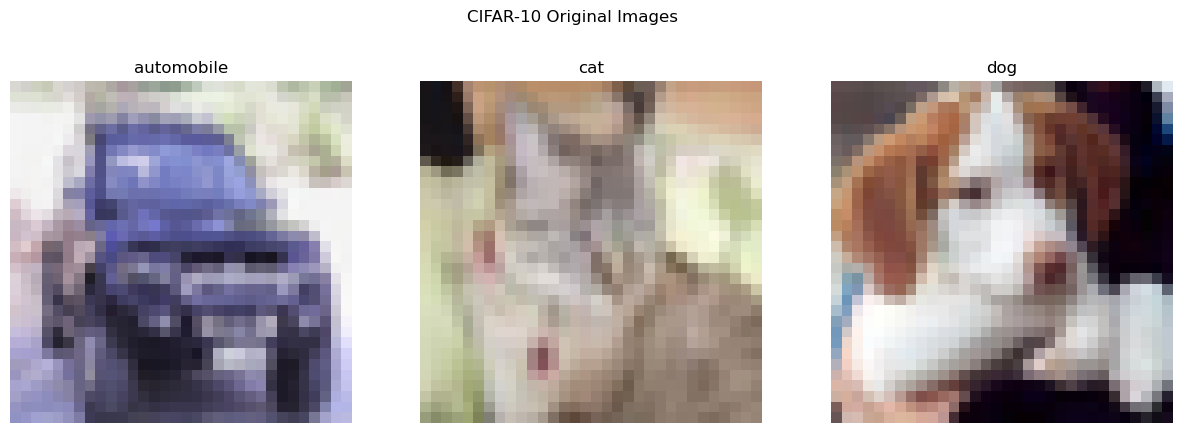

In [739]:

for test_images, test_labels in test_dataloader:
    show_images(test_images, test_labels, title="CIFAR-10 Original Images")  
    break
plt.show()

1/5th Time Epoch: 0/30

1/5th Time Epoch: 1/30

train_loss 0.04230411366923996
test_loss: 0.03402586262437362
Time 19.53963851928711
SSIM 0.575561917280849


1/5th Time Epoch: 2/30

train_loss 0.03198935428772436
test_loss: 0.030546726941873756
Time 19.1722993850708
SSIM 0.6305225280266774


1/5th Time Epoch: 3/30

train_loss 0.02956517451845319
test_loss: 0.028781134988876838
Time 19.953466653823853
SSIM 0.6585045215449755


1/5th Time Epoch: 4/30

train_loss 0.028118675870015798
test_loss: 0.028363888800332818
Time 19.602206468582153
SSIM 0.6656323384635056


1/5th Time Epoch: 5/30

train_loss 0.02733451453373408
test_loss: 0.027080007321849654
Time 19.50981903076172
SSIM 0.6790709646442269


1/5th Time Epoch: 6/30

train_loss 0.0266408230347173
test_loss: 0.026044486868607847
Time 19.900184869766235
SSIM 0.6951001580757431


1/5th Time Epoch: 7/30

train_loss 0.02608938832931659
test_loss: 0.02603220272384867
Time 19.476978540420532
SSIM 0.6959255171727531


1/5th Time Epoch: 8/30

train_loss 0.025559667983780735
test_loss: 0.02528864428212371
Time 19.507054328918457
SSIM 0.7049163481857204


1/5th Time Epoch: 9/30

train_loss 0.025253059799828188
test_loss: 0.0257440597479102
Time 19.72733974456787
SSIM 0.7095580267000802


1/5th Time Epoch: 10/30

train_loss 0.024929652128683026
test_loss: 0.02543240912918803
Time 19.908066749572754
SSIM 0.7084505678732184


1/5th Time Epoch: 11/30

train_loss 0.02454195921416478
test_loss: 0.024852182103108755
Time 20.365495681762695
SSIM 0.7135551036158695


1/5th Time Epoch: 12/30

train_loss 0.024239972352867237
test_loss: 0.024418680068058304
Time 20.48659586906433
SSIM 0.716934310484536


1/5th Time Epoch: 13/30

train_loss 0.02400262519488554
test_loss: 0.024500616932217077
Time 20.357672214508057
SSIM 0.7203535377224789


1/5th Time Epoch: 14/30

train_loss 0.023722149660367797
test_loss: 0.024132560938596725
Time 20.135268926620483
SSIM 0.7230231263969518


1/5th Time Epoch: 15/30

train_loss 0.023423953758328772
test_loss: 0.02357621582908721
Time 19.11528706550598
SSIM 0.730248826968519


1/5th Time Epoch: 16/30

train_loss 0.023219426784216596
test_loss: 0.023603847368231304
Time 19.085355520248413
SSIM 0.732718431496922


1/5th Time Epoch: 17/30

train_loss 0.02300546915672929
test_loss: 0.023039375325735613
Time 19.260952949523926
SSIM 0.739844876754133


1/5th Time Epoch: 18/30

train_loss 0.022784975893281
test_loss: 0.02317155006377003
Time 19.067276000976562
SSIM 0.738307817072808


1/5th Time Epoch: 19/30

train_loss 0.022587846264319346
test_loss: 0.02279448841663101
Time 19.42135524749756
SSIM 0.7419644926167741


1/5th Time Epoch: 20/30

train_loss 0.022367088929237916
test_loss: 0.023151488550290276
Time 19.29583215713501
SSIM 0.739096021350426


1/5th Time Epoch: 21/30

train_loss 0.02218683210708906
test_loss: 0.022762415294028535
Time 18.865230560302734
SSIM 0.7451819030544425


1/5th Time Epoch: 22/30

train_loss 0.022034980490079622
test_loss: 0.02248941215721867
Time 19.089786052703857
SSIM 0.7469404679310473


1/5th Time Epoch: 23/30

train_loss 0.021797108575892267
test_loss: 0.022678700098885767
Time 19.072107076644897
SSIM 0.7460441521451443


1/5th Time Epoch: 24/30

train_loss 0.021775343295786998
test_loss: 0.022643748647238636
Time 18.890241384506226
SSIM 0.7470017226436471


1/5th Time Epoch: 25/30

train_loss 0.021522865761690737
test_loss: 0.02228386855766743
Time 18.847227811813354
SSIM 0.7504646830920931


1/5th Time Epoch: 26/30

train_loss 0.02137929408827706
test_loss: 0.02206326761766325
Time 18.90245246887207
SSIM 0.7515742831592318


1/5th Time Epoch: 27/30

train_loss 0.021218206252321563
test_loss: 0.022202351448845258
Time 18.661184787750244
SSIM 0.7520223403278785


1/5th Time Epoch: 28/30

train_loss 0.021074209376559842
test_loss: 0.021681694879750663
Time 18.869232416152954
SSIM 0.756232543836666


1/5th Time Epoch: 29/30

train_loss 0.02093893209534228
test_loss: 0.021676321690784223
Time 18.737202882766724
SSIM 0.7579602327527879
train_loss 0.020892297625160584
test_loss: 0.022401424549237083
Time 18.657182931900024
SSIM 0.7546850103366224
SSIM: 0.7546850103366224
loss_train: 0.0209,loss_test: 0.0224
MSE: 0.022401424549237083
ProcessingTime: 581.4799942970276


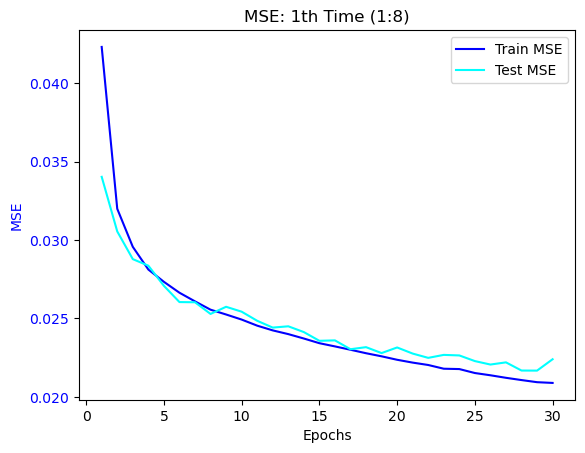

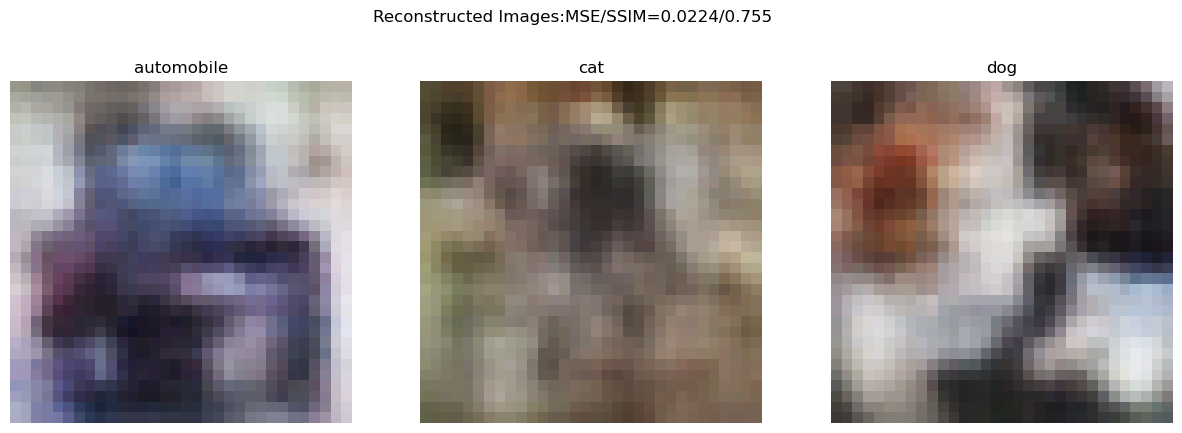

2/5th Time Epoch: 1/30

train_loss 0.04908602257899921
test_loss: 0.04116395978799349
Time 19.11228609085083
SSIM 0.4609209691421895


2/5th Time Epoch: 2/30

train_loss 0.0399848505892717
test_loss: 0.03764648414865325
Time 19.201306581497192
SSIM 0.5210071221182618


2/5th Time Epoch: 3/30

train_loss 0.03736442128372619
test_loss: 0.03633633708652062
Time 19.154295206069946
SSIM 0.5488306253771239


2/5th Time Epoch: 4/30

train_loss 0.036003142681039504
test_loss: 0.0356578933004337
Time 19.14929461479187
SSIM 0.5631337678885158


2/5th Time Epoch: 5/30

train_loss 0.03499294748372587
test_loss: 0.03472579652561417
Time 19.10328507423401
SSIM 0.5824718196180803


2/5th Time Epoch: 6/30

train_loss 0.034347409225257156
test_loss: 0.033663795860130574
Time 19.19530463218689
SSIM 0.5923325743856309


2/5th Time Epoch: 7/30

train_loss 0.033593406100445394
test_loss: 0.033796732655808896
Time 19.20930814743042
SSIM 0.5926268183732335


2/5th Time Epoch: 8/30

train_loss 0.033095870038394426
test_loss: 0.032925645125251785
Time 19.217309713363647
SSIM 0.6047298493264597


2/5th Time Epoch: 9/30

train_loss 0.03266147115860906
test_loss: 0.033727765578446506
Time 19.209308385849
SSIM 0.598134380352648


2/5th Time Epoch: 10/30

train_loss 0.03230034269849815
test_loss: 0.03196757506060449
Time 19.151294469833374
SSIM 0.6187874825694893


2/5th Time Epoch: 11/30

train_loss 0.03195930120375608
test_loss: 0.032934182995482335
Time 19.14829421043396
SSIM 0.6126949221273011


2/5th Time Epoch: 12/30

train_loss 0.03164087321199572
test_loss: 0.031426774337887764
Time 19.074277877807617
SSIM 0.6278393487387066


2/5th Time Epoch: 13/30

train_loss 0.031271162335677526
test_loss: 0.031089057650747178
Time 19.062275409698486
SSIM 0.6353309146965607


2/5th Time Epoch: 14/30

train_loss 0.030920777331723277
test_loss: 0.031160303568349607
Time 19.08728265762329
SSIM 0.6328539554076859


2/5th Time Epoch: 15/30

train_loss 0.030661362297166032
test_loss: 0.030360019306027438
Time 19.079280853271484
SSIM 0.6454551310478887


2/5th Time Epoch: 16/30

train_loss 0.030339515103441676
test_loss: 0.030904524853523775
Time 19.141292333602905
SSIM 0.638654035103472


2/5th Time Epoch: 17/30

train_loss 0.030154654322682745
test_loss: 0.030148669723657113
Time 19.163297176361084
SSIM 0.6472701181339312


2/5th Time Epoch: 18/30

train_loss 0.02993069841619343
test_loss: 0.030058814000479783
Time 19.137291431427002
SSIM 0.6458266339724577


2/5th Time Epoch: 19/30

train_loss 0.029687526581041953
test_loss: 0.030029127421446995
Time 19.110285997390747
SSIM 0.6526137243343305


2/5th Time Epoch: 20/30

train_loss 0.029374588909737594
test_loss: 0.03010625682205339
Time 19.20730757713318
SSIM 0.6536183085622667


2/5th Time Epoch: 21/30

train_loss 0.02924107523906566
test_loss: 0.029709674064305764
Time 19.118287801742554
SSIM 0.6567346763007248


2/5th Time Epoch: 22/30

train_loss 0.028900706149694866
test_loss: 0.029658901658427866
Time 19.130290269851685
SSIM 0.6546938690958144


2/5th Time Epoch: 23/30

train_loss 0.028692221140388944
test_loss: 0.029491305634190765
Time 19.13729166984558
SSIM 0.6641338776938522


2/5th Time Epoch: 24/30

train_loss 0.028528092943532084
test_loss: 0.029124863893736766
Time 19.13529133796692
SSIM 0.6654609977444516


2/5th Time Epoch: 25/30

train_loss 0.028278796669200558
test_loss: 0.02849543063983887
Time 19.10728430747986
SSIM 0.6703969798510587


2/5th Time Epoch: 26/30

train_loss 0.0281216806262884
test_loss: 0.02851849061118651
Time 19.16329789161682
SSIM 0.6699794855298875


2/5th Time Epoch: 27/30

train_loss 0.027896687902910326
test_loss: 0.02898622025983243
Time 19.155296564102173
SSIM 0.6721085423155676


2/5th Time Epoch: 28/30

train_loss 0.02773623919243093
test_loss: 0.028654229178836074
Time 19.152297496795654
SSIM 0.6728187293945989


2/5th Time Epoch: 29/30

train_loss 0.02754162316736968
test_loss: 0.028010932657914826
Time 19.19630527496338
SSIM 0.6749490242970141
train_loss 0.02739865932127704
test_loss: 0.028126552087973943
Time 19.129289865493774
SSIM 0.671570827689352
SSIM: 0.671570827689352
loss_train: 0.0274,loss_test: 0.0281
MSE: 0.028126552087973943
ProcessingTime: 574.3388109207153


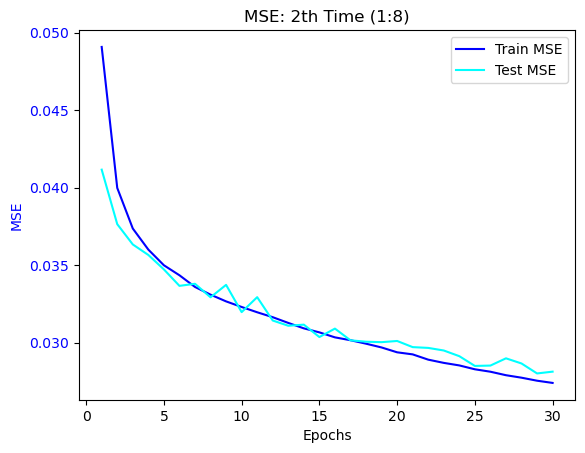

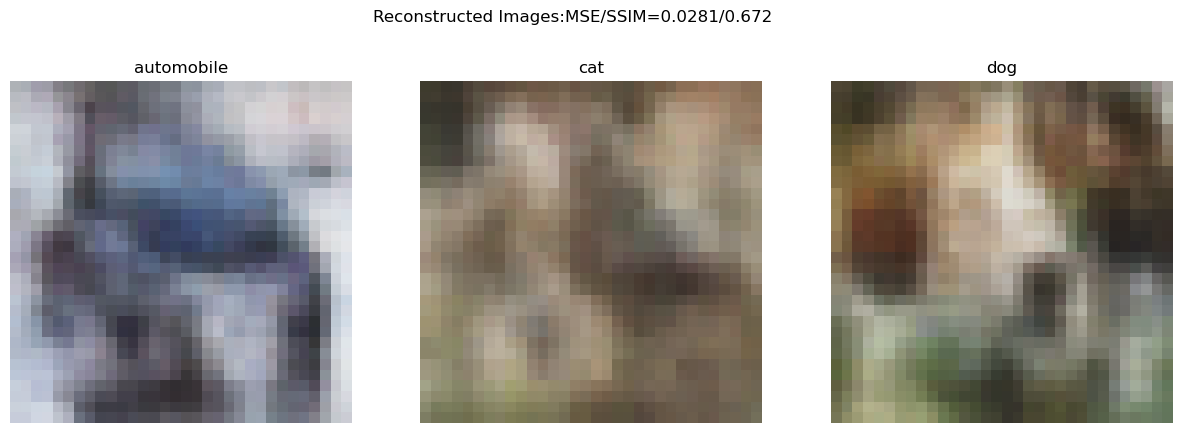

3/5th Time Epoch: 1/30

train_loss 0.047302084143661785
test_loss: 0.0388232767110384
Time 19.15129590034485
SSIM 0.49035927955108355


3/5th Time Epoch: 2/30

train_loss 0.03752433355240261
test_loss: 0.036092861543727824
Time 19.13529133796692
SSIM 0.5524891516830348


3/5th Time Epoch: 3/30

train_loss 0.035240069007896405
test_loss: 0.03436410804338093
Time 19.189303874969482
SSIM 0.5763256082051917


3/5th Time Epoch: 4/30

train_loss 0.03387503361191286
test_loss: 0.0335855581620826
Time 19.174301624298096
SSIM 0.5991974442820006


3/5th Time Epoch: 5/30

train_loss 0.032849040730377595
test_loss: 0.03210093748248831
Time 19.15029525756836
SSIM 0.6123313247403012


3/5th Time Epoch: 6/30

train_loss 0.03210757830944817
test_loss: 0.03202697993079318
Time 19.31733226776123
SSIM 0.6164123016067699


3/5th Time Epoch: 7/30

train_loss 0.031543242990437065
test_loss: 0.031243275638811196
Time 19.167298793792725
SSIM 0.6257383959202827


3/5th Time Epoch: 8/30

train_loss 0.03104683596764684
test_loss: 0.03126085386906244
Time 19.133291006088257
SSIM 0.6286650707450094


3/5th Time Epoch: 9/30

train_loss 0.03050770950706109
test_loss: 0.03054048566595663
Time 19.112288236618042
SSIM 0.6394370130345791


3/5th Time Epoch: 10/30

train_loss 0.030130777022112972
test_loss: 0.030836244290576704
Time 19.096283197402954
SSIM 0.6401198295098317


3/5th Time Epoch: 11/30

train_loss 0.029806781098094134
test_loss: 0.029760390449362465
Time 19.206307411193848
SSIM 0.6482534778269031


3/5th Time Epoch: 12/30

train_loss 0.029599510938348367
test_loss: 0.029508182566754425
Time 19.147294521331787
SSIM 0.650956764251371


3/5th Time Epoch: 13/30

train_loss 0.029255482337206526
test_loss: 0.029677853554109984
Time 19.206308603286743
SSIM 0.656938326509693


3/5th Time Epoch: 14/30

train_loss 0.02904162641681369
test_loss: 0.029584613569741007
Time 19.129290103912354
SSIM 0.6563224347331856


3/5th Time Epoch: 15/30

train_loss 0.028752306366668028
test_loss: 0.028823949868165995
Time 19.140303134918213
SSIM 0.6624889539766915


3/5th Time Epoch: 16/30

train_loss 0.028360904606483172
test_loss: 0.028774604413516914
Time 19.17530059814453
SSIM 0.6684858663172661


3/5th Time Epoch: 17/30

train_loss 0.028180165773691118
test_loss: 0.028567675618997104
Time 19.145293712615967
SSIM 0.6702915188632433


3/5th Time Epoch: 18/30

train_loss 0.028030640414684935
test_loss: 0.029394515660367434
Time 19.130290508270264
SSIM 0.6713672084144399


3/5th Time Epoch: 19/30

train_loss 0.027711410704247482
test_loss: 0.028955754576415957
Time 19.17830514907837
SSIM 0.6728332042694092


3/5th Time Epoch: 20/30

train_loss 0.0275239803687767
test_loss: 0.027828614710818364
Time 19.03426957130432
SSIM 0.6758406388608715


3/5th Time Epoch: 21/30

train_loss 0.027333482957023487
test_loss: 0.0280032149409946
Time 19.115286827087402
SSIM 0.6798492813412147


3/5th Time Epoch: 22/30

train_loss 0.02717152709984566
test_loss: 0.028089777743325956
Time 19.073277950286865
SSIM 0.6801123800156992


3/5th Time Epoch: 23/30

train_loss 0.026924867530727325
test_loss: 0.027639347187514547
Time 19.119287967681885
SSIM 0.6853880761544916


3/5th Time Epoch: 24/30

train_loss 0.026727858087633883
test_loss: 0.027354256992664517
Time 19.117287635803223
SSIM 0.6874417323100416


3/5th Time Epoch: 25/30

train_loss 0.026720808118657992
test_loss: 0.027227203491367872
Time 19.168298482894897
SSIM 0.6894070709807963


3/5th Time Epoch: 26/30

train_loss 0.026383040925425948
test_loss: 0.02692118570019927
Time 19.223312377929688
SSIM 0.6972942797443534


3/5th Time Epoch: 27/30

train_loss 0.02631518370984003
test_loss: 0.026678020346768295
Time 19.12663173675537
SSIM 0.695103874689416


3/5th Time Epoch: 28/30

train_loss 0.02609973966770465
test_loss: 0.026799299294435527
Time 19.182302236557007
SSIM 0.693505109110965


3/5th Time Epoch: 29/30

train_loss 0.025956231305170854
test_loss: 0.02704557889624487
Time 19.20232605934143
SSIM 0.6946101324467719
train_loss 0.025879424470274345
test_loss: 0.02670278671327271
Time 19.167298555374146
SSIM 0.697293291363535
SSIM: 0.697293291363535
loss_train: 0.0259,loss_test: 0.0267
MSE: 0.02670278671327271
ProcessingTime: 574.6152546405792


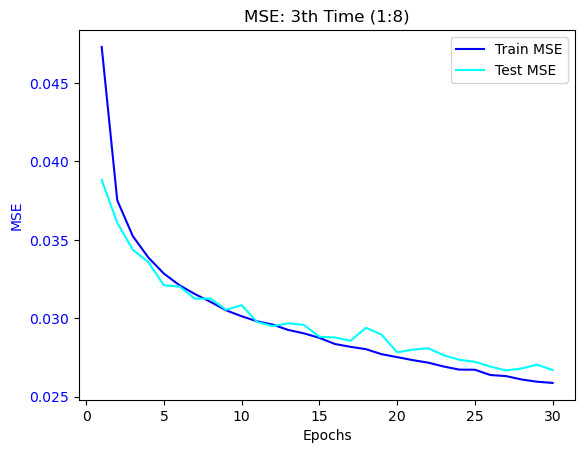

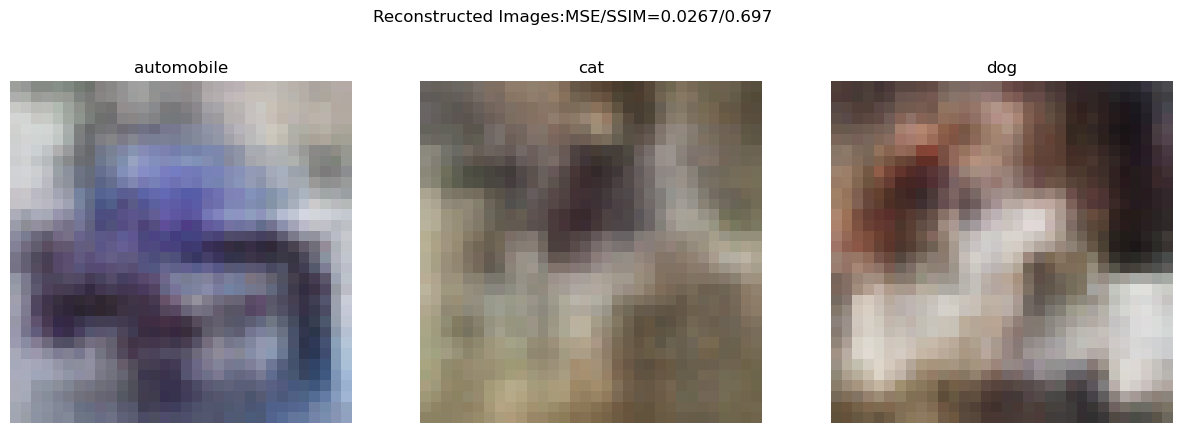

4/5th Time Epoch: 1/30

train_loss 0.04409525411017715
test_loss: 0.036722928945776785
Time 19.37434434890747
SSIM 0.5383245937431915


4/5th Time Epoch: 2/30

train_loss 0.03495750551009574
test_loss: 0.03432419877263564
Time 19.262319564819336
SSIM 0.5839822005621994


4/5th Time Epoch: 3/30

train_loss 0.032746630942310825
test_loss: 0.031213745073992993
Time 20.500600814819336
SSIM 0.6230656353733207


4/5th Time Epoch: 4/30

train_loss 0.031342492669897005
test_loss: 0.030274647229079958
Time 19.969032764434814
SSIM 0.640171870400634


4/5th Time Epoch: 5/30

train_loss 0.030299988915891293
test_loss: 0.03017543701902975
Time 19.25931978225708
SSIM 0.6487404794632634


4/5th Time Epoch: 6/30

train_loss 0.029492509749043935
test_loss: 0.029605656673636616
Time 19.30632972717285
SSIM 0.6592848361292972


4/5th Time Epoch: 7/30

train_loss 0.028862581952758457
test_loss: 0.02859437783967845
Time 19.239316701889038
SSIM 0.6672694909421704


4/5th Time Epoch: 8/30

train_loss 0.028367182949696052
test_loss: 0.028405587389310705
Time 19.23431420326233
SSIM 0.6761337480967557


4/5th Time Epoch: 9/30

train_loss 0.02786819315741739
test_loss: 0.027585197216536426
Time 19.26282572746277
SSIM 0.6825207328494591


4/5th Time Epoch: 10/30

train_loss 0.027481283797213183
test_loss: 0.028280075285819512
Time 19.303320169448853
SSIM 0.6766221545919587


4/5th Time Epoch: 11/30

train_loss 0.02705703248434207
test_loss: 0.027117275550395628
Time 19.335336685180664
SSIM 0.6923818384544759


4/5th Time Epoch: 12/30

train_loss 0.026761140674352646
test_loss: 0.02705058684171755
Time 19.217310190200806
SSIM 0.6931679354438299


4/5th Time Epoch: 13/30

train_loss 0.026439319281360073
test_loss: 0.02669684077271178
Time 19.262319564819336
SSIM 0.6929509209681161


4/5th Time Epoch: 14/30

train_loss 0.0261326587909018
test_loss: 0.02684540270910233
Time 19.29732847213745
SSIM 0.699597284009185


4/5th Time Epoch: 15/30

train_loss 0.025840566796072
test_loss: 0.02617790078437781
Time 19.99464988708496
SSIM 0.7008003343509722


4/5th Time Epoch: 16/30

train_loss 0.025681779317348205
test_loss: 0.026158305097229873
Time 19.5758957862854
SSIM 0.7005246085456655


4/5th Time Epoch: 17/30

train_loss 0.025362737414896336
test_loss: 0.025906715329877938
Time 19.641602754592896
SSIM 0.7070165238802946


4/5th Time Epoch: 18/30

train_loss 0.025097784012213083
test_loss: 0.02603667953252038
Time 20.052046537399292
SSIM 0.707009390185151


4/5th Time Epoch: 19/30

train_loss 0.0249690043184992
test_loss: 0.025461779294323316
Time 19.8034405708313
SSIM 0.7099974630754206


4/5th Time Epoch: 20/30

train_loss 0.02467023001035766
test_loss: 0.025389670877705647
Time 20.035629987716675
SSIM 0.7126991929887216


4/5th Time Epoch: 21/30

train_loss 0.024558829510455852
test_loss: 0.025380553206122373
Time 19.633896589279175
SSIM 0.714732410032538


4/5th Time Epoch: 22/30

train_loss 0.024299281947028913
test_loss: 0.02471148074144804
Time 20.091061115264893
SSIM 0.7213215873211245


4/5th Time Epoch: 23/30

train_loss 0.02406066575604479
test_loss: 0.0247785452800461
Time 19.949302196502686
SSIM 0.7227441653420653


4/5th Time Epoch: 24/30

train_loss 0.023920559974582603
test_loss: 0.024724579333693167
Time 18.987258195877075
SSIM 0.7248475483701199


4/5th Time Epoch: 25/30

train_loss 0.023731834752975828
test_loss: 0.024152307900824125
Time 20.685922384262085
SSIM 0.7283559788631487


4/5th Time Epoch: 26/30

train_loss 0.023632859158546418
test_loss: 0.023967062417842164
Time 20.644640922546387
SSIM 0.7316423360305496


4/5th Time Epoch: 27/30

train_loss 0.023466629502565964
test_loss: 0.02474245209765585
Time 20.19053030014038
SSIM 0.7266297506380685


4/5th Time Epoch: 28/30

train_loss 0.023275787954020986
test_loss: 0.024361018327218067
Time 20.428580284118652
SSIM 0.7317334255085716


4/5th Time Epoch: 29/30

train_loss 0.023131806227137976
test_loss: 0.02406522579774072
Time 20.271547317504883
SSIM 0.7311071889309944
train_loss 0.022967608335911466
test_loss: 0.023670600302800347
Time 20.04849648475647
SSIM 0.7353624112998383
SSIM: 0.7353624112998383
loss_train: 0.0230,loss_test: 0.0237
MSE: 0.023670600302800347
ProcessingTime: 591.8585200309753


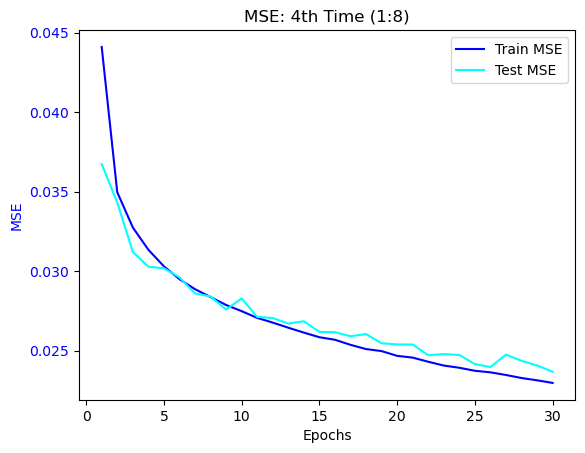

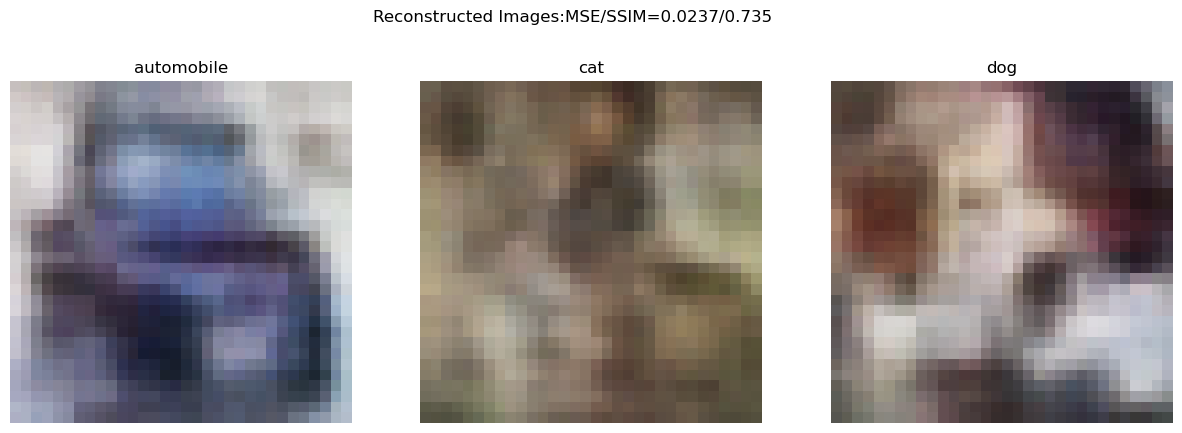

5/5th Time Epoch: 1/30

train_loss 0.04812622643873819
test_loss: 0.04132146921150292
Time 20.419580936431885
SSIM 0.46010336657113665


5/5th Time Epoch: 2/30

train_loss 0.03997154189916828
test_loss: 0.0387413478633271
Time 19.480369091033936
SSIM 0.5192041872422907


5/5th Time Epoch: 3/30

train_loss 0.03765855647642594
test_loss: 0.037068558314555806
Time 19.397855043411255
SSIM 0.5545771476588671


5/5th Time Epoch: 4/30

train_loss 0.03631255865249487
test_loss: 0.035990075220035604
Time 19.111791849136353
SSIM 0.567550155180919


5/5th Time Epoch: 5/30

train_loss 0.035428859298224646
test_loss: 0.03520380012408088
Time 19.575896739959717
SSIM 0.5759050838554962


5/5th Time Epoch: 6/30

train_loss 0.03460560482271644
test_loss: 0.034134736968369425
Time 19.094282388687134
SSIM 0.5950893329668648


5/5th Time Epoch: 7/30

train_loss 0.03395713225502492
test_loss: 0.03394970080897778
Time 19.17029881477356
SSIM 0.5972881845281094


5/5th Time Epoch: 8/30

train_loss 0.033507334016015765
test_loss: 0.03324568014639088
Time 18.915242195129395
SSIM 0.6042630823352669


5/5th Time Epoch: 9/30

train_loss 0.03300476878347909
test_loss: 0.03348092333991316
Time 19.003766536712646
SSIM 0.6078387906279745


5/5th Time Epoch: 10/30

train_loss 0.03268516485286338
test_loss: 0.03354403551054906
Time 18.999333143234253
SSIM 0.6196799436702004


5/5th Time Epoch: 11/30

train_loss 0.03214965270989386
test_loss: 0.03246353269566463
Time 19.127291202545166
SSIM 0.622068378744246


5/5th Time Epoch: 12/30

train_loss 0.031838200305162184
test_loss: 0.032256703918116005
Time 19.21430993080139
SSIM 0.6252088810824141


5/5th Time Epoch: 13/30

train_loss 0.031503268515171906
test_loss: 0.032133520592617086
Time 19.955509185791016
SSIM 0.63261732270446


5/5th Time Epoch: 14/30

train_loss 0.031109599806273074
test_loss: 0.03157542888782447
Time 20.574018478393555
SSIM 0.6346529820297337


5/5th Time Epoch: 15/30

train_loss 0.03074803358167791
test_loss: 0.03245323587539075
Time 19.962931156158447
SSIM 0.6314743976049786


5/5th Time Epoch: 16/30

train_loss 0.03048675906989733
test_loss: 0.03138941663164127
Time 19.924152851104736
SSIM 0.6351978884467596


5/5th Time Epoch: 17/30

train_loss 0.030197546653011265
test_loss: 0.03109882689446588
Time 19.802441120147705
SSIM 0.6440941193435765


5/5th Time Epoch: 18/30

train_loss 0.02986442207184899
test_loss: 0.031180617104791388
Time 19.17280340194702
SSIM 0.643690478198136


5/5th Time Epoch: 19/30

train_loss 0.029695806858103597
test_loss: 0.03113603445736668
Time 19.22131109237671
SSIM 0.6452668942982638


5/5th Time Epoch: 20/30

train_loss 0.02944021574352556
test_loss: 0.030277567762362807
Time 19.451866388320923
SSIM 0.6535302189332021


5/5th Time Epoch: 21/30

train_loss 0.029075488848302064
test_loss: 0.030417408912053592
Time 19.285324811935425
SSIM 0.6580179363866395


5/5th Time Epoch: 22/30

train_loss 0.02888837717282955
test_loss: 0.030213655927513218
Time 19.51288080215454
SSIM 0.6545824687692183


5/5th Time Epoch: 23/30

train_loss 0.02864625950432037
test_loss: 0.02989426307097266
Time 20.805959463119507
SSIM 0.6613493773001659


5/5th Time Epoch: 24/30

train_loss 0.028446968425722682
test_loss: 0.029788355755655072
Time 20.63744831085205
SSIM 0.6659799089914635


5/5th Time Epoch: 25/30

train_loss 0.028190155658880462
test_loss: 0.029737327837302714
Time 19.935067415237427
SSIM 0.6641624562347992


5/5th Time Epoch: 26/30

train_loss 0.027977849430668993
test_loss: 0.02920631734253485
Time 19.32240080833435
SSIM 0.6683697843853431


5/5th Time Epoch: 27/30

train_loss 0.02774521743264192
test_loss: 0.029716070081236997
Time 19.289877891540527
SSIM 0.6686420765104173


5/5th Time Epoch: 28/30

train_loss 0.027604756219422117
test_loss: 0.0289645073110167
Time 19.265320777893066
SSIM 0.6703231364865846


5/5th Time Epoch: 29/30

train_loss 0.027368840654297254
test_loss: 0.028992064061421383
Time 19.399537563323975
SSIM 0.6747671184660513
train_loss 0.027270726535631264
test_loss: 0.0292375701232047
Time 19.433790683746338
SSIM 0.6675586677804778
SSIM: 0.6675586677804778
loss_train: 0.0273,loss_test: 0.0292
MSE: 0.0292375701232047
ProcessingTime: 586.462660074234


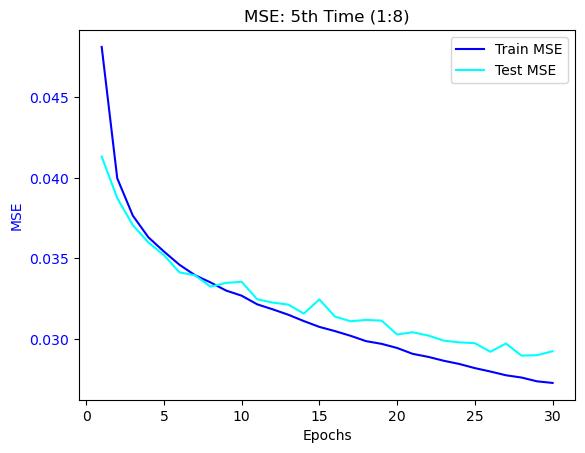

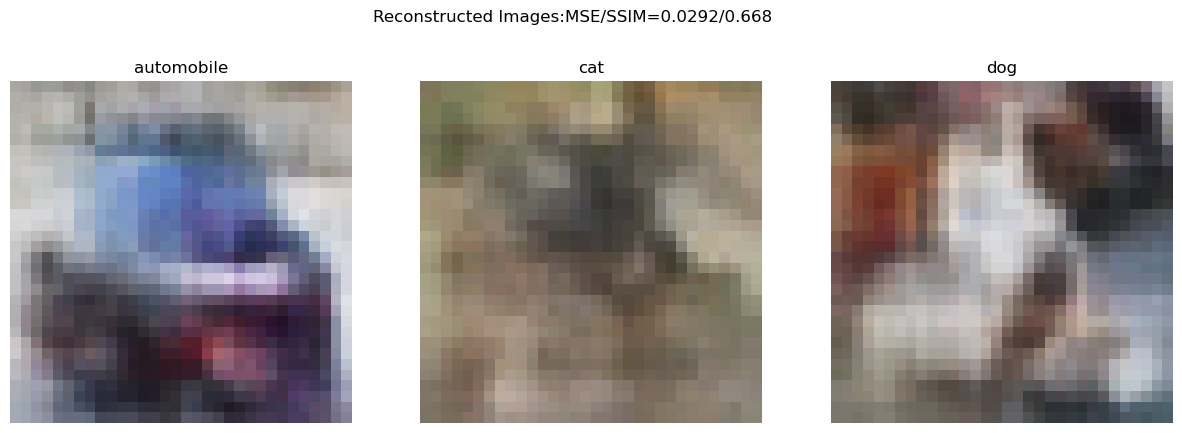

In [740]:

img_size = 32
channels = 3

DofIN = channels*img_size**2 ##CIFAR10 32*32*3
leverage = 8 ##圧縮倍率
kernel_size = 4 #カーネルサイズ
ch = 64##64
pos_embed_dim = 8##16
max_epochs = 30#50

num_try = 5##5

All_last_loss = []
All_last_ssim = []
All_loss_test = []
All_pro_time = []


for num_times in range(num_try): 

    model = AutoEncoder(img_size,channels,kernel_size,leverage,ch,pos_embed_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    loss_train_ = []
    loss_test_ = []
    pro_time_ = []

            
    for epoch in range(max_epochs):

        sys.stderr.write('\r%d/%dth Time Epoch: %d/%d' % (num_times+1,num_try, epoch, max_epochs)) 
        sys.stderr.flush()

        loss_train = 0
        loss_test = 0
        ssim_test_0=0

        start_time1 = time.time()
        for (x,t) in train_dataloader:
                    
            x, t = x.to(device), t.to(device)
            y = model(x).to(device)

            loss = criterion(y, x.view(x.size(0), -1)) 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
       
        loss_train_avg = loss_train / len(train_dataloader)
        end_time1 = time.time()
        pro_time_.append(end_time1-start_time1)


        with torch.no_grad():
            for x, t in test_dataloader:
                x, t = x.to(device), t.to(device)
                y = model(x).to(device)
                loss = criterion(y, x.view(x.size(0), -1))
                ssim_test0 = ssim_loss(y.view(-1, channels, img_size, img_size).cpu().numpy().transpose(0, 2, 3, 1), 
                                  x.view(-1, channels, img_size, img_size).cpu().numpy().transpose(0, 2, 3, 1), 
                                  channel_axis=-1,data_range=1.0)
                loss_test += loss.item()
                ssim_test_0 += ssim_test0

        loss_test_avg = loss_test / len(test_dataloader)
        ssim_test_avg = ssim_test_0 / len(test_dataloader)
        
        print('train_loss',loss_train_avg)
        print('test_loss:',loss_test_avg)
        print('Time',end_time1-start_time1)
        print('SSIM',ssim_test_avg)
        
        loss_train_.append(loss_train_avg)
        loss_test_.append(loss_test_avg)
        
        if epoch == max_epochs-1:
            All_loss_test.append(loss_test_)
            All_pro_time.append(sum(pro_time_)) 
            All_last_ssim.append(ssim_test_avg) 
    Last_loss_test = loss_test_[-1]
    All_last_loss.append(Last_loss_test)
    print('SSIM:',ssim_test_avg)
    print(f"loss_train: {loss_train_avg:.4f},loss_test: {loss_test_avg:.4f}")
    print("MSE:",Last_loss_test)
    print('ProcessingTime:',sum(pro_time_))

    fig, ax1 = plt.subplots()
    ax1.plot(range(1,len(loss_train_)+1), loss_train_, label="Train MSE", color = 'blue')
    ax1.plot(range(1,len(loss_test_)+1), loss_test_, label="Test MSE", color = 'cyan')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('MSE', color = 'blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend()

    title = 'MSE: %dth Time (1:%d)'%(num_times+1,leverage) #
    plt.title(title)
    file_name = '%d_%dth(1_%d)_mse.png'%(int(formatted_date),num_times+1,leverage)
    full_path = os.path.join(save_directory, file_name)
    plt.savefig(full_path, dpi=100, bbox_inches='tight')
    plt.show()

    with torch.no_grad():
        test_images = test_images.to(device)
        reconstructed_images = model(test_images)
        image_title = "Reconstructed Images:MSE/SSIM=%.4f/%.3f"%(Last_loss_test,ssim_test_avg)
        show_images(reconstructed_images.cpu(),test_labels, image_title)
        file_name = '%d_ReImage%dth(1_%d).png'%(int(formatted_date),num_times+1,leverage)
        full_path = os.path.join(save_directory, file_name)
        plt.savefig(full_path, dpi=100, bbox_inches='tight')
        plt.show()




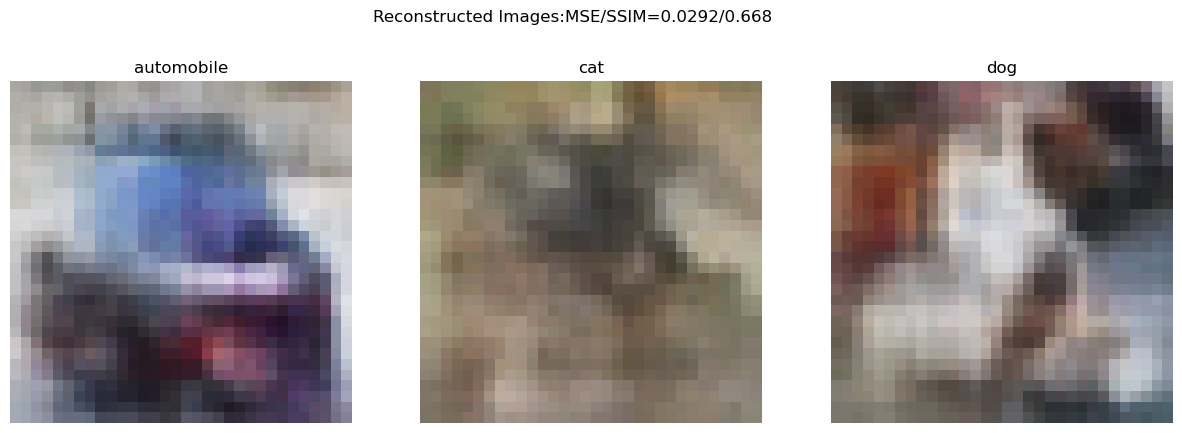

In [741]:
with torch.no_grad():
    test_images = test_images.to(device)
    reconstructed_images = model(test_images)
    image_title = "Reconstructed Images:MSE/SSIM=%.4f/%.3f"%(Last_loss_test,ssim_test_avg)
    show_images(reconstructed_images.cpu(),test_labels, image_title)
    file_name = '%d_ReImage%dth(1_%d).png'%(int(formatted_date),num_times+1,leverage)
    full_path = os.path.join(save_directory, file_name)
    plt.savefig(full_path, dpi=100, bbox_inches='tight')
    plt.show()

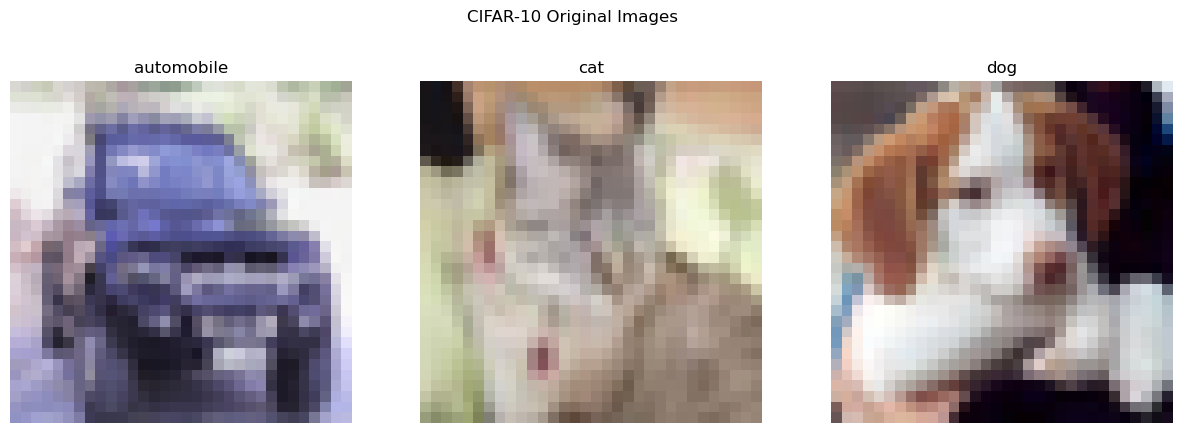

In [742]:
for test_images, test_labels in test_dataloader:
    show_images(test_images, test_labels, title="CIFAR-10 Original Images")             
    break
plt.show()

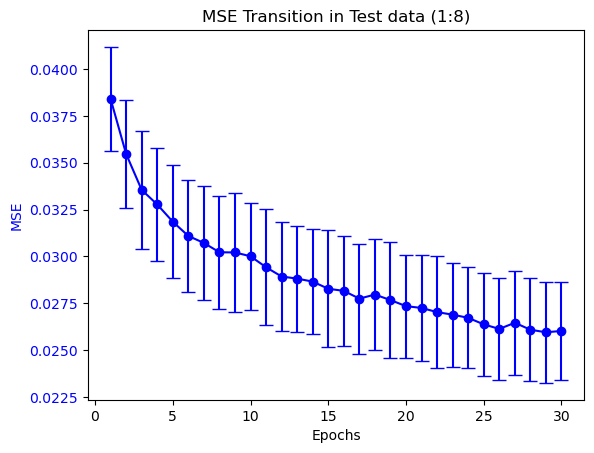

In [743]:
epochs = len(All_loss_test[0])  # エポック数（各リストの長さ）
num_dimensions = len(All_loss_test)  # 埋め込み次元数の数

# 各エポックごとに平均と標準偏差を計算
mean_loss = np.mean(All_loss_test, axis=0)
std_loss = np.std(All_loss_test, axis=0)

# グラフの描画
fig, ax1 = plt.subplots()

# 平均値の折れ線グラフと誤差範囲（標準偏差の誤差棒）
ax1.errorbar(
    x=range(1, epochs + 1), y=mean_loss, yerr=std_loss,
    fmt='-o', color='blue', ecolor='blue', capsize=5, 
)

# 軸ラベルやタイトルの設定
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.title('MSE Transition in Test data (1:%d)' % leverage)
file_name = '%d_MSE_errorbar.png'%(int(formatted_date))
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')

plt.show()

In [744]:
import csv
SSIM_mean = np.mean(All_last_ssim)
SSIM_best = np.max(All_last_ssim)
SSIM_bestID = np.argmax(All_last_ssim)+1
SSIM_worst = np.min(All_last_ssim)
SSIM_worstID = np.argmin(All_last_ssim)+1

MSE_mean = np.mean(All_last_loss)
MSE_best = np.min(All_last_loss)
MSE_bestID = np.argmin(All_last_loss)+1
MSE_worst = np.max(All_last_loss)
MSE_worstID = np.argmax(All_last_loss)+1

data = {
        "": ["SSIM", "MSE"],
    "Average": [SSIM_mean, MSE_mean],
    "Best ID": [SSIM_bestID, MSE_bestID],
    "Best": [SSIM_best, MSE_best],
    "Worst ID": [SSIM_worstID, MSE_worstID],
    "Worst": [SSIM_worst, MSE_worst],
}

df = pd.DataFrame(data)

print(df)

file_name = '%d_exTable.csv'%(int(formatted_date))
full_path = os.path.join(save_directory, file_name)
df.to_csv(full_path, index=False)

          Average  Best ID      Best  Worst ID     Worst
0  SSIM  0.705294        1  0.754685         5  0.667559
1   MSE  0.026028        1  0.022401         5  0.029238


In [745]:
pro_time_mean = sum(All_pro_time)/len(All_pro_time)
data2 = {
    "Index": list(range(1, len(All_pro_time) + 1)),  # インデックス（1から開始）
    "Processing Time": All_pro_time                # 各処理時間
}

df2 = pd.DataFrame(data2)
df2.loc[""] = ["Average", pro_time_mean]

print(df2)

     Index  Processing Time
0        1       581.479994
1        2       574.338811
2        3       574.615255
3        4       591.858520
4        5       586.462660
   Average       581.751048


In [746]:
import csv
save_directory1 = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoEncoder_data005','texts') 
print(save_directory1)
os.makedirs(save_directory1, exist_ok=True)
file_name = 'CIFAR10_NL1-8_list.csv'##
full_path = os.path.join(save_directory1, file_name)
with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(All_loss_test)

C:\Users\Scent\OneDrive\CODES\konishi_AutoEncoder\AutoEncoder_data005\texts
